## **Face recognition**

We have a set of pictures:

**Set_1**: person_01.png to person_07.png

**Set_2**: person_08.png to person_19.png

**Set_3**: person_20.png to person_31.png

**Set_4**: person_32.png to person_45.png

**Set_5**: person_46.png to person_64.png

Sources: https://www.geeksforgeeks.org/ml-face-recognition-using-eigenfaces-pca-algorithm/

In [107]:
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier as knc
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from PIL import Image

In [108]:
# load images
use_drive = True

image_path = '/content/drive/MyDrive/faces'

images_dir = None
if (use_drive):
    from google.colab import drive
    drive.mount('/content/drive')
    images_dir = os.path.join("/content/drive/MyDrive/", 'faces')
else:
    home_directory = os.path.expanduser('~')
    images_dir = os.path.join(home_directory, '/faces')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
set_dict = {
    'Set_1': (1, 7),
    'Set_2': (8, 19),
    'Set_3': (20, 31),
    'Set_4': (32, 45),
    'Set_5': (46, 64),
}

def loadImages(path, set_number):
  '''
  Function that loads images from a given set_X, where X = [1, 5]
  '''

  if set_number not in set_dict: return None

  # find the range of the pictures
  first, last = set_dict[set_number]

  img_list = list()
  lab_list = list()

  # open images in the given path and process them
  for picture in os.listdir(path):
    picture_num = int(picture[9]+picture[10])
    if picture_num < first or picture_num > last: continue

    # open image
    img = Image.open(os.path.join(path, picture))

    # preprocess image
    img = img.resize((50, 50))
    img = np.asarray(img)
    img.reshape(-1)
    img = img.flatten()

    # save mean and standard deviation
    img_mean = img.mean()
    img_std  = img.std()

    img = (img-img_mean)/img_std
    img_list.append(img)

    # add label
    if picture[6] == '0': lab_list.append(int(picture[7]))
    else:                 lab_list.append(int(picture[6] + picture[7]))

  return img_list, lab_list

In [110]:
# load all sets
X1, Y1 = loadImages(image_path, 'Set_1')
X2, Y2 = loadImages(image_path, 'Set_2')
X3, Y3 = loadImages(image_path, 'Set_3')
X4, Y4 = loadImages(image_path, 'Set_4')
X5, Y5 = loadImages(image_path, 'Set_5')

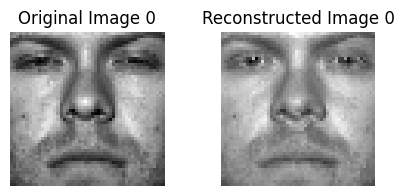

In [111]:
# compute mean face
mean_face = np.mean(X1, axis=0)

# center the data
centered_data = X1-mean_face

# perform PCA with d = 30
d = 30
pca = PCA(n_components=d)
pca.fit(centered_data)

# get the top d eigenvectors
eigenvectors = pca.components_

# choose a random image for reconstruction
img_index = np.random.randint(len(X1))
random_image = X1[img_index]

# project the random image onto the eigenvectors
coefficients = pca.transform(random_image.reshape(1, -1))

# reconstruct the image
reconstructed_image = (mean_face + np.dot(coefficients, eigenvectors)).reshape(50, 50)

# display both the original and the reconstructed image
fig, axes = plt.subplots(1, 2, figsize=(5, 2))

# plot original image
axes[0].imshow(random_image.reshape(50, 50), cmap='gray')
axes[0].set_title(f"Original Image {img_index}")
axes[0].axis('off')

# plot reconstructed image
axes[1].imshow(reconstructed_image, cmap='gray')
axes[1].set_title(f"Reconstructed Image {img_index}")
axes[1].axis('off')

plt.show()

We can see, the model performance is very satisfactory. The quality of the reconstructed image is very high, as both images are very similar.

The Custom_PCA class reduces data dimensionality while preserving variance.Methods include `fit_transform` for fitting and transforming data, `transform` for projecting new data, and `inverse_transform` for reconstructing original data from principal components. The implementation involves computing the covariance matrix, performing eigenvalue decomposition, and selecting the top components.

In [112]:
class Custom_PCA:
    def __init__(self, num_components):
        self.num_components = num_components

    def fit_transform(self, X):

        # compute the covariance matrix
        mean = np.mean(X, axis=0)
        centered_data = X - mean
        covariance_matrix = np.cov(centered_data, rowvar=False)

        # eigenvalue decomposition
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

        # sort eigenvectors based on eigenvalues
        idx = np.argsort(eigenvalues)[::-1]
        sorted_eigenvectors = eigenvectors[:, idx]

        # select the top num_components eigenvectors
        self.principal_components = sorted_eigenvectors[:, :self.num_components]

        # project the data onto the principal components
        projected_data = np.dot(centered_data, self.principal_components)

        # reconstruct the data
        self.reconstructed_data = np.dot(projected_data, self.principal_components.T) + mean

        return projected_data

    def transform(self, X_val):
        return np.dot(X_val, self.principal_components)

    def inverse_transform(self, X):
        return np.dot(X, self.principal_components.T) + np.mean(X, axis=0)

def preprocess_images(img):
    return np.array(img)

def reshape_img(img):
    new_img = preprocess_images(img)
    return new_img.reshape(new_img.shape[0], -1)

In [113]:
def calc_mean_squared_error(d_values):

    # store the mean squared errors
    errors = list()

    for d in d_values:
        pca_model = Custom_PCA(d)
        _ = pca_model.fit_transform(reshape_img(X1))

        # reconstruct images
        reconstructed_img = pca_model.reconstructed_data

        # calculate mean squared error for each image
        mse = np.mean(np.square(reshape_img(X1) - reconstructed_img))
        errors.append(mse)

    return errors

def plot_mse_error(d_val, err):
    plt.figure(figsize=(8, 6))
    plt.plot(d_val, err, marker='o')
    plt.xlabel('Number of Components (d)')
    plt.ylabel('Mean Squared Error')
    plt.title('Eigenfaces Reconstruction Error')
    plt.grid(True)
    plt.show()

Values of d = [2, 12, 22, 32, 42, 52, 62, 72, 82, 92, 102, 112, 122, 132, 142, 152, 162, 172, 182, 192]


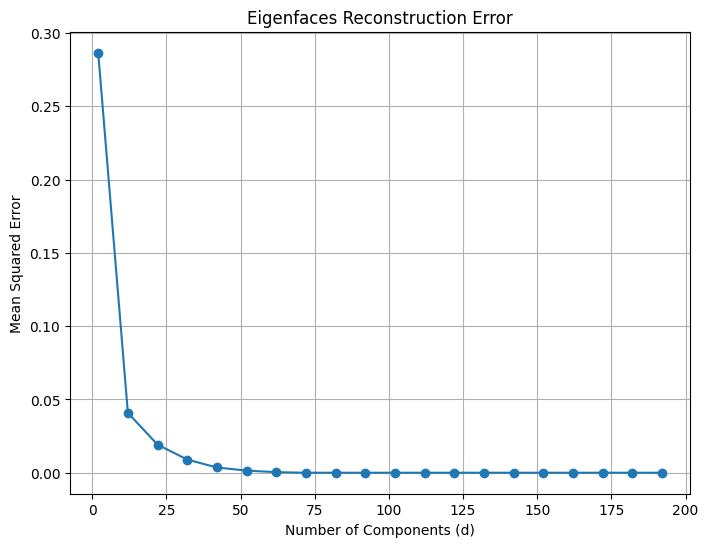

In [114]:
# choose d value uniformly from all the range of values
num_components = 200
d_values = np.arange(2, num_components+1, 10)

print(f"Values of d = {d_values.tolist()}")

errors = calc_mean_squared_error(d_values)
plot_mse_error(d_values, errors)

#### **Observations**

- We notice a significant drop in error from 2 components to 12.
- Every drop in error after that is less significant.
- As expected, the is no benefit in using more components than features (d=72).

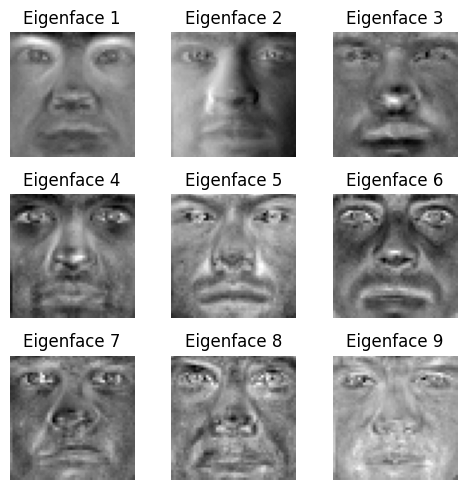

In [115]:
# get the top 9 eigenvectors
top_eigenvectors = eigenvectors[:9]

# reshape the eigenvectors into the original image shape
eigenfaces = top_eigenvectors.reshape((9, 50, 50))

# plot the eigenfaces
fig, axes = plt.subplots(3, 3, figsize=(5, 5))
axes = axes.ravel()

for i in range(9):
    axes[i].imshow(eigenfaces[i], cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Eigenface {i+1}")

plt.tight_layout()
plt.show()

We notice, as expected, that each eigenvector captures a different part and shape of the face. Interpreting what specific part and/or shape is not an easy task, but here are my remarks:
- **Eigenvectors 1, 2, 7** could be capturing the eye shape as eyes are prominent facial features.
- **Eigenvectors 3, 5, 6** could be capturing the mouth/lips shape as they are features known for their distinct shapes and expressions.
- **Eigenvectors 4, 8, 9** could be capturing more general information (facial structure, head orientation etc).

In [116]:
# store the accuracy of each set
accuracy_set1 = list()
accuracy_set2 = list()
accuracy_set3 = list()
accuracy_set4 = list()
accuracy_set5 = list()

for d in d_values:
    pca_d = Custom_PCA(d)

    X_train_d = pca_d.fit_transform(X1)
    X2_d      = pca_d.transform(reshape_img(X2))
    X3_d      = pca_d.transform(reshape_img(X3))
    X4_d      = pca_d.transform(reshape_img(X4))
    X5_d      = pca_d.transform(reshape_img(X5))

    knc_d = knc(n_neighbors=1, p=2)
    knc_d.fit(X_train_d, Y1)

    # train using PCA with d components
    accuracy_set1.append(knc_d.score(X_train_d, Y1))
    accuracy_set2.append(knc_d.score(X2_d, Y2))
    accuracy_set3.append(knc_d.score(X3_d, Y3))
    accuracy_set4.append(knc_d.score(X4_d, Y4))
    accuracy_set5.append(knc_d.score(X5_d, Y5))

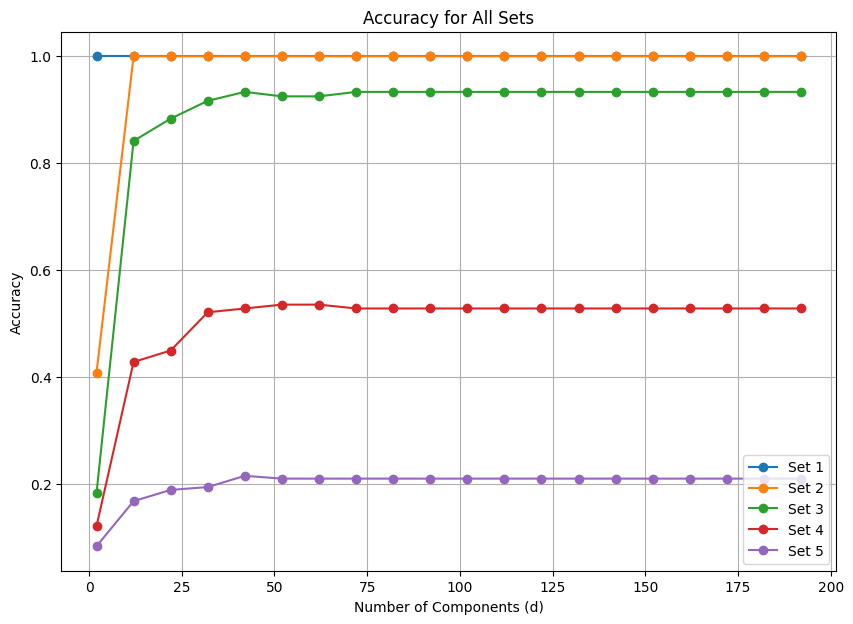

In [117]:
def plot_all_sets(d_val, *sets):
    plt.figure(figsize=(10, 7))
    for set_num, set_list in enumerate(sets, start=1):
        plt.plot(d_val, set_list, marker='o', label=f'Set {set_num}')

    plt.xlabel('Number of Components (d)')
    plt.ylabel('Accuracy')
    plt.title('Accuracy for All Sets')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_all_sets(d_values, accuracy_set1, accuracy_set2, accuracy_set3, accuracy_set4, accuracy_set5)

We get the best performance in set 2 by using **d = 9**, where we the score is 1, correctly predicting all images from the set. This surprisingly good result stems from its similarity with the images of the train set (set 1).

In [118]:
# PCA with the number of components chosen
d = 32
pca32 = Custom_PCA(d)

X_train_32 = pca32.fit_transform(X1)
X2_32      = pca32.transform(X2)
X3_32      = pca32.transform(X3)
X4_32      = pca32.transform(X4)
X5_32      = pca32.transform(X5)

# train using PCA with 32 components
knc32 = knc(n_neighbors=1, p=2)
knc32.fit(X_train_32, Y1)

print(f"Evaluating k-nearest neighbours (d={d}):")
print("Training set:",  knc32.score(X_train_32, Y1))
print("2nd set:     ", knc32.score(X2_32, Y2))
print("3rd set:     ", knc32.score(X3_32, Y3))
print("4th set:     ", knc32.score(X4_32, Y4))
print("5th set:     ", knc32.score(X5_32, Y5))

Evaluating k-nearest neighbours (d=32):
Training set: 1.0
2nd set:      1.0
3rd set:      0.9166666666666666
4th set:      0.5214285714285715
5th set:      0.19473684210526315


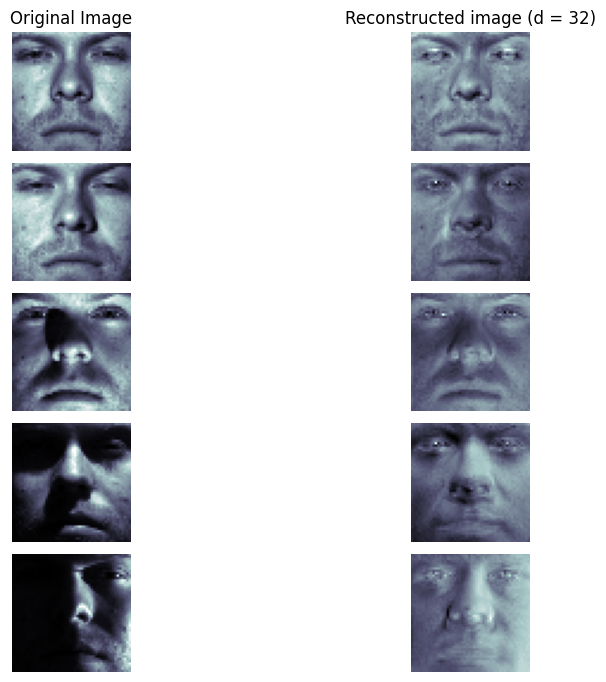

In [119]:
# plot the images
plt.figure(figsize=(15, 10))

for (X, X32, i) in [(X1, X_train_32, 1), (X2, X2_32, 4), (X3, X3_32, 7), (X4, X4_32, 10), (X5, X5_32, 13)]:
    img0 = X[0]
    img1 = pca32.inverse_transform(X32[0])

    plt.subplot(6, 3, i)
    plt.axis('off')
    if i == 1:
        plt.title("Original Image")
    plt.imshow(img0.reshape(50, 50), cmap='bone')

    plt.subplot(6, 3, i+1)
    plt.axis('off')
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    if i == 1:
        plt.title(f"Reconstructed image (d = {d})")
    plt.imshow(img1.reshape(50, 50), cmap='bone')

plt.show()

- For **sets 1 & 2** we notice a very high quality in their respective reconstructed image quality.
- For **set 3** we can also see high quality in the reconstructed image quality.
- For **set 4** we can cleary notice the drop in image quality from the previous set (set 3).
- For **set 5** the quality is very poor (as demonstrated from the score).

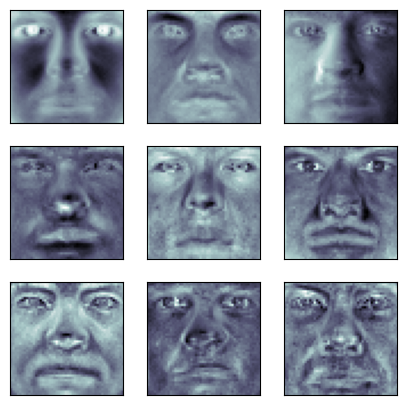

In [120]:
singular_vecs = np.linalg.svd(X1, full_matrices=False)

# plot the result
fig = plt.figure(figsize=(5, 5))
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
    ax.imshow(singular_vecs[2][i].reshape(50, 50), cmap=plt.cm.bone)

The eigenvectors from PCA and the right singular vectors from SVD are closely related as both are used for dimensionality reduction. Though, we can see that they slightly differ. That is because:

- SVD can offer insights into the original data.
- SVD is more numerically stable.